# Lab 3 — dimensionality reduction
**Internet Analytics - Lab 3**

---

**Group:** *K*

**Names:**

* *Robin Lang*
* *Kim Lan Phan Hoang*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

import pickle

%matplotlib inline
plt.style.use("ggplot")

relevance_file_name = "relevance_array.npy"

## Exercice 3.1

### Construct the data matrix using PySpark on the cluster, create the array containing all the ratings from `genome-scores.txt`

In [61]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [10]:
n_movies = movies.map(lambda x: x["movieId"]).max()
n_tags = tags.map(lambda x: x["tagId"]).max()

In [11]:
print("movies:", n_movies, "| tags:", n_tags)

movies: 131262 | tags: 1128


In [2]:
relevance_array = np.zeros((n_tags, n_movies), dtype=float)

for i in data.toLocalIterator():
    # we substract 1 from each index, to avoid the forst row / colon being empty,
    # as the ids start at 1
    relevance_array[i["tagId"]-1][i["movieId"]-1] = i["relevance"]

NameError: name 'n_tags' is not defined

The following code allows us to use the previously done computations, so that we don't need to relaunch the expensive computation of the matrix, nor need the cluster, freeing up ressources for others.

Save the computed array to a file on disk

In [4]:
np.save(relevance_file_name, relevance_array)

NameError: name 'relevance_array' is not defined

In [2]:
relevance_array = np.load(relevance_file_name)

n_movies = len(relevance_array[1])
n_tags = len(relevance_array)

### Plot the variance of each dimension / tag.

In [3]:
# compute the variance of each tag and save it into an array
rel_var = []
for i in relevance_array:
    rel_var.append(np.var(i))

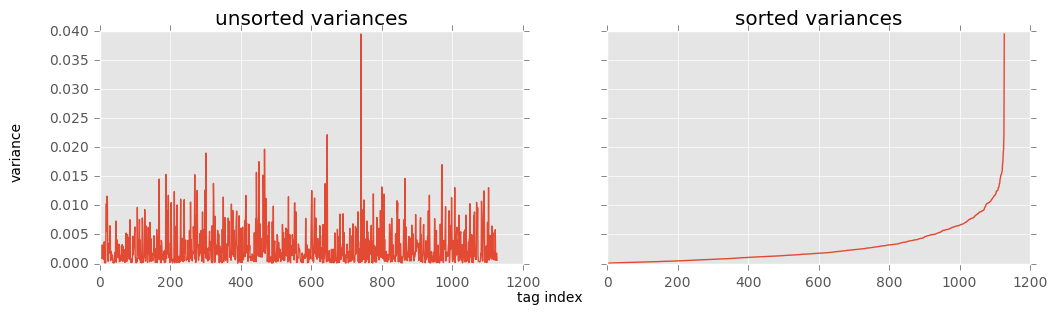

In [34]:
# plot the variances
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
fig.text(0.5, 0.0, 'tag index', ha='center')
fig.text(0.05, 0.5, 'variance', va='center', rotation='vertical')

ax1.plot(rel_var)
ax1.set_title("unsorted variances")

ax2.plot(sorted(rel_var))
ax2.set_title("sorted variances")
plt.show()


### Plot the eigenvalues of the covariance matrix.

In [3]:
# compute covariance matrix
rel_cov = np.cov(relevance_array)
# the formula is:
#   rel_cov = 1/n_tags * relevance_array.T @ relevance_array
# which gives the same result as the above formula, but is way slower

# compute the eigenvalues and -vectors
rel_eigvals, rel_eigvecs = la.eigh(rel_cov)

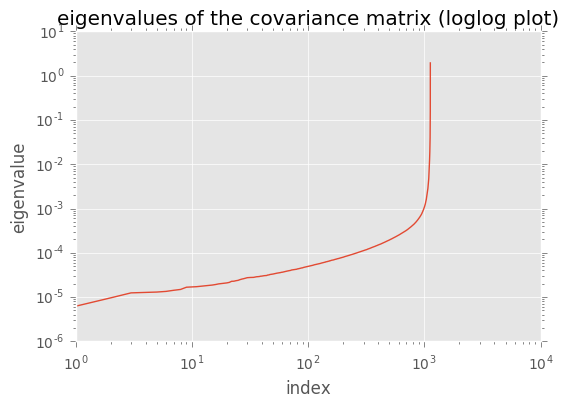

In [31]:
# plot the eigenvalues
plt.loglog(rel_eigvals)
plt.title("eigenvalues of the covariance matrix (loglog plot)")
plt.xlabel("index")
plt.ylabel("eigenvalue")
plt.show()

### Explain the implications for dimensionality reduction.

Most eigenvalues are very small (between $10^{-5}$ and $10^{-3}$), with very few large values. <br>
Since the dimensionality of the data is carried by the eigenvalues, this means that few eigenvalues are required to keep a significant portion of the variability (large eigenvalues capture a large part of the values).

For example:

**How many principal directions do you need to capture $2 \over 3$ of the variability in the data?**

In [28]:
# compute the sum of all eigenvalues.
# 2/3 of the variability will be carried by eigenvalues that cover 2/3 of that sum
sum_eig = sum(rel_eigvals)
s = 0
n_eigvals = len(rel_eigvals)
count = 0

while s < sum_eig*2/3:
    # the eigenvalues are sorted from smallest to largest,
    # so to get the n-th largest, all that is needed is to get the
    # n-th last element from the array
    s += rel_eigvals[n_eigvals-count-1]
    count += 1

print("to capture 2/3 of the variability you need", count, "principal directions")


to capture 2/3 of the variability you need 3 principal directions


## Exercice 3.2

### For the five first principal directions, find the 10 tags that have the highest and lowest coordinates in that direction.

In [29]:
# first 5 principal directions, which are the eigenvectors whose eigenvalues are the largest
rel_dirs = []
for i in range(5):
    rel_dirs.append(rel_cov @ rel_eigvecs[-i-1])

In [122]:
# retrieve the name of a tag by index
def getTagName(i):
    return tags.filter(lambda x: x["tagId"] == i+1).take(1)[0]["tag"]

# print the names from a list of tag indices
def printTags(l, dir):
    for i in l:
        print("   ", dir[i], ":", getTagName(i))

In [123]:
def find_tags(direction):
    # find indeces of 10 highest / lowest entries
    top10 = np.argsort(-direction)[:10]
    bottom10 = np.argsort(direction)[:10]

    print("  top10 (largest to smallest):")
    printTags(top10, direction)
    print("  bottom10 (smallest to largest):")
    printTags(bottom10, direction)

In [124]:
count = ["1st", "2nd", "3rd", "4th", "5th"]

for i in range(5):
    print(count[i], "principal direction:")
    find_tags(rel_dirs[i])
    print("")

1st principal direction:
  top10 (largest to smallest):
    0.00408974341015 : original
    0.00306611406518 : great ending
    0.00293642113118 : mentor
    0.00292593174661 : dialogue
    0.00277424141257 : great
    0.00276465655914 : story
    0.00273015860636 : storytelling
    0.00268612542398 : good
    0.0026220352338 : good soundtrack
    0.00255990893073 : catastrophe
  bottom10 (smallest to largest):
    1.93366137854e-05 : hannibal lecter
    3.01643721523e-05 : iraq war
    3.52018897445e-05 : swedish
    3.87716669739e-05 : batman
    4.1120358451e-05 : vietnam war
    4.30617257492e-05 : beatles
    4.99244950592e-05 : 9/11
    5.02116196097e-05 : iran
    5.33817393121e-05 : neo-nazis
    5.38058466111e-05 : aardman

2nd principal direction:
  top10 (largest to smallest):
    0.00119078919816 : predictable
    0.000996382298644 : action
    0.000988587903866 : so bad it's funny
    0.000890407629481 : bad plot
    0.000818849036364 : good action
    0.000804662743984 : 

### What concepts would you use to describe these dimensions?

The first direction has high values for tags including story, original, whereas most tags in the bottom 10 are about war. 

One might note that the first and the fifth top10 and bottom10 tags are reversed. Also, the "good" word is mainly situated in the top 10 tags.

### Create a dict which maps every tag to it's coordinates in the first 5 principal directions

In [155]:
# construct the dict
tag_dict = {}
for i in tags.toLocalIterator():
    tmp = []
    for j in range(5):
        tmp.append(rel_dirs[j][i["tagId"]-1])
    tag_dict[i["tag"]] = tmp

In [151]:
# save to file
with open('tag_dict.txt', 'wb') as file:
    pickle.dump(tag_dict, file)

In [156]:
# reopen file
with open("tag_dict.txt", "rb") as file:
    tag_dict_load = pickle.load(file)

## Exercice 3.3

### Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. 

In [126]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [127]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
for movie in movies:
#    print(movie)
    pass

In [128]:
projected_x = [] # first principal direction
projected_y = [] # second principal direction

for i in movies:
    projected_x.append(np.dot(relevance_array.T[i[0]-1], rel_dirs[0]))
    projected_y.append(np.dot(relevance_array.T[i[0]-1], rel_dirs[1]))

In [129]:
# Continuous colors
from matplotlib.colors import rgb2hex 

# colors:   0% -> red
#          50% -> yellow
#         100% -> green
# interpolated in between
def rottenColor(val):
    if val<0.5:
        return rgb2hex([1.0, 2*val, 0.0])
    else:
        return rgb2hex([2*(1.0-val), 1.0, 0.0])

source = ColumnDataSource(
    data={
        "x": projected_x,
        "y": projected_y,
        "name": [x[1] for x in movies],
        "color": [rottenColor(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=960, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=1.0)
show(p)

### Explain the coordinates of a few of the movies.

The first principal direction is on the X direction, the second is on Y. A result close to 0 means that movie is perfectly represented by that principal direction. For example, "King's Speech" is very close to 0 on the Y axism which means that its tags are almost perfectly represented by that direction.

### How do the PCA directions correlate with the Rotten Tomatoes score?